In [2]:
import geopandas as gpd
import requests
import time
import shapely
import geopandas_osm.osm
import numpy as np
import descartes as d
import math
%matplotlib notebook

In [3]:
leftbound = -75.5898
rightbound = -75.5740
upperbound = 40.1391
lowerbound = 40.1134
bbox = [(leftbound,lowerbound ), (rightbound,lowerbound), (rightbound,upperbound), (leftbound,upperbound)]
poly = shapely.geometry.Polygon(bbox)
df = geopandas_osm.osm.query_osm('way', poly, recurse='down')


geopandas_osm/osm.py:299: FutureWarning: by argument to sort_index is deprecated, pls use .sort_values(by=...)
  df = df.sort_index(by='index')[['lon', 'lat']]


In [4]:
arr=["highway","residential", "primary", "secondary","tertiary","unclassified", "cycleway"]
df=df[df.highway.isin(arr)]
df["geometry"]


2     LINESTRING (-75.582399 40.128127, -75.581869 4...
3     LINESTRING (-75.588481 40.140452, -75.588418 4...
4     LINESTRING (-75.58474200000001 40.12023, -75.5...
5     LINESTRING (-75.58092000000001 40.130136, -75....
6     LINESTRING (-75.585381 40.132703, -75.585033 4...
7     LINESTRING (-75.589359 40.117143, -75.58929500...
8     LINESTRING (-75.5783229 40.1306533, -75.578250...
9     LINESTRING (-75.58195499999999 40.133631, -75....
10    LINESTRING (-75.578626 40.134604, -75.57861200...
12    LINESTRING (-75.583094 40.112462, -75.58320500...
13    LINESTRING (-75.58058800000001 40.123706, -75....
14    LINESTRING (-75.580197 40.128909, -75.581074 4...
15    LINESTRING (-75.580426 40.124818, -75.58059 40...
17    LINESTRING (-75.58511799999999 40.130374, -75....
18    LINESTRING (-75.579583 40.113681, -75.57960199...
19    LINESTRING (-75.58516299999999 40.129724, -75....
20    LINESTRING (-75.572425 40.136861, -75.573086 4...
21    LINESTRING (-75.58092000000001 40.130136, 

In [14]:
newdata = gpd.GeoDataFrame()
newdata["street name"]=None
newdata["geometry"]=None
streetnewdata = gpd.GeoDataFrame()
streetnewdata["street name"]=None
streetnewdata["geometry"]=None

In [6]:
elevations = dict()

In [7]:
print elevations

{}


In [8]:
all_coords_list = []
for geometry in df["geometry"]:
    for coord in geometry.coords:
        all_coords_list.append(coord)

In [9]:
def is_intersection(val):
    num_matches = 0
    for i in all_coords_list:
        if val == i:
            num_matches +=1
    
    if(num_matches > 1):
        return True
    else:
        return False

def get_elev_diff(point1, point2):
        return get_elev(point1)-get_elev(point2)
def get_elev(point):
    if(point in elevations):
        return elevations[point]
    else:
        rqstring = "https://maps.googleapis.com/maps/api/elevation/json?locations="+str(point[0])+","+str(point[1])
        elevation=requests.get(rqstring)
        elev = elevation.json()["results"][0]["elevation"]
        elevations[point] = elev
        time.sleep(.1)
        return elev
def distance(point1, point2):
    return math.hypot(point2[0]-point1[0], point2[1]-point1[1])
def dot(a, b):
    return (a[0]*b[0])+(a[1]*b[1])
def get_vector(point, origin):
    return (point[0]-origin[0], point[1]-origin[1])
def get_anchor_point(point1, point2, elev_diff):
    if(elev_diff == 0):
        return False
    xv = get_vector(point1, point2)[0]
    yv = get_vector(point1, point2)[1]
    anchor = (-yv, xv)
    anchor = [i*elev_diff/distance(point1, point2) for i in anchor] 
    return (point1[0]+anchor[0], point1[1]+anchor[1])

def get_baseline_angle(anchor, other):
    return math.atan((other[1]-anchor[1])/(other[0]-anchor[0]))

In [31]:
get_anchor_point((2.47,2.9),(1.23, 2.37), 5)

(0.5048793414552035, 7.497640786029338)

In [30]:
projection_anchor = (1.23, 2.37)
project_point = (2,4)
project_end = (5,4)
a = get_vector(projection_anchor, project_point)
b = get_vector(projection_anchor,project_end)
print projection_anchor[0]-a[0],projection_anchor[1]-a[1]
print projection_anchor[0]-b[0],projection_anchor[1]-b[1]
print a, b
try:
    c = dot(a, b)/dot(b,b)
    print c
except:
    c = 0
    print a, b, elev_diff
    print "Zero division"
c = (c*b[0], c*b[1])
p = (projection_anchor[0]-c[0], projection_anchor[1]-c[1])
print "p: ", p

2.0 4.0
5.0 4.0
(-0.77, -1.63) (-3.77, -1.63)
0.32957118638
p:  (2.472483372654092, 2.907201033800045)


In [45]:
new_index = -1
for index, name, geometry in zip(df.index.values, df["name"],df["geometry"]):
    new_index +=1
    coords = geometry.coords
    coords_list = [i for i in coords]
    intersection_list = [0]
    index=1
    for coord in coords[1:-1]:
        if(is_intersection(coord)):
            intersection_list.append(index)
        index+=1
    intersection_list.append(int(len(coords)-1))

    prev_index = 0    
    if(len(intersection_list) > 2):
        for i in intersection_list[1:-1]:
            #print "section from point ", coords[prev_index], "to point", coords[i], ":",
            point1 = coords[prev_index]
            point2 = coords[i]
            print point1, point2
            elev1 = get_elev(point1)
            elev2 = get_elev(point2)
            elev_diff=round((elev1-elev2)*.00001,7)
            baseline_angle = 0
            anchor_point = get_anchor_point(point1, point2, elev_diff)
            
            if(elev_diff > 0):
                anchor_point = get_anchor_point(point2, point1, elev_diff)
                point1, point2 = point2, point1
            elif(elev_diff == 0):
                anchor_point = point1
            if(anchor_point == False):
                anchor_point = point1
            
            else:
                baseline_angle = get_baseline_angle(anchor_point, point2)
            seg_arr = coords_list[prev_index+1:i-1]
            new_points = []
            new_points.append(point1)
            projection_anchor = point1
            project_end = point2
            for point in seg_arr[1:]:
                a = get_vector(point, anchor_point)
                b = get_vector(point2, anchor_point)
                project_point = point
                a = get_vector(projection_anchor, project_point)
                b = get_vector(projection_anchor,project_end)
                try:
                    c = dot(a, b)/dot(b,b)
                except:
                    c = 0
                    print a, b, elev_diff
                    print "Zero division"
                c = (c*b[0], c*b[1])
                p = (projection_anchor[0]-c[0], projection_anchor[1]-c[1])
                cur_point_elev_diff = elev_diff=round((get_elev(point)-elev2)*.00001,7)
                p_with_elev_diff = get_anchor_point(p,projection_anchor, cur_point_elev_diff)
                print "p: ", p
                new_points.append(p_with_elev_diff)
            seg_arr = new_points
            if(anchor_point !=False):
                seg_arr.append(anchor_point)
            prev_index = i

    else:
        
        elev_diff=round(get_elev_diff(coords[0], coords[1])*.00001,7)
        seg_arr = coords_list  
        anchor = get_anchor_point(coords[0],coords[1], elev_diff)
        seg_arr.append(anchor) if anchor !=False else seg_arr.append((seg_arr[0][0],seg_arr[0][1]-elev_diff))
    
    if(len(seg_arr) > 2):
        poly = shapely.geometry.Polygon(seg_arr)
        line = shapely.geometry.LineString(seg_arr[:-1])
        try:
            streetnewdata.loc[new_index, "geometry"] = line
            streetnewdata.loc[new_index, "street name"] = name
            newdata.loc[new_index, "geometry"] = poly
            newdata.loc[new_index, "street name"] = name
        except:
            continue

(-75.582399, 40.128127) (-75.581869, 40.128588)
(-75.581869, 40.128588) (-75.581074, 40.129278)
(-75.581074, 40.129278) (-75.580435, 40.129712)
(-75.585381, 40.132703) (-75.581955, 40.133631)
p:  (-75.58459984113009, 40.13291459236173)
p:  (-75.58456628125055, 40.132923682720225)
p:  (-75.58450776057833, 40.13293953420411)
p:  (-75.58441834008188, 40.13296375551781)
p:  (-75.58434454489478, 40.132983744406786)
p:  (-75.58426811031934, 40.1330044482264)
p:  (-75.58416337723726, 40.133032817257394)
p:  (-75.58408504130153, 40.13305403609812)
p:  (-75.58398881049794, 40.13308010211848)
p:  (-75.58351062925898, 40.13320962698414)
p:  (-75.58336193592176, 40.13324990352149)
(-75.581955, 40.133631) (-75.578626, 40.134604)
p:  (-75.58081704206711, 40.1339636023036)
p:  (-75.58076648425833, 40.13397837933813)
p:  (-75.58066636106109, 40.13400764334261)
p:  (-75.58056718794161, 40.134036629658404)
p:  (-75.58049695773894, 40.134057156539505)
p:  (-75.58043129167335, 40.13407634941479)
p:  (-75.

TypeError: 'bool' object has no attribute '__getitem__'

<IPython.core.display.Javascript object>


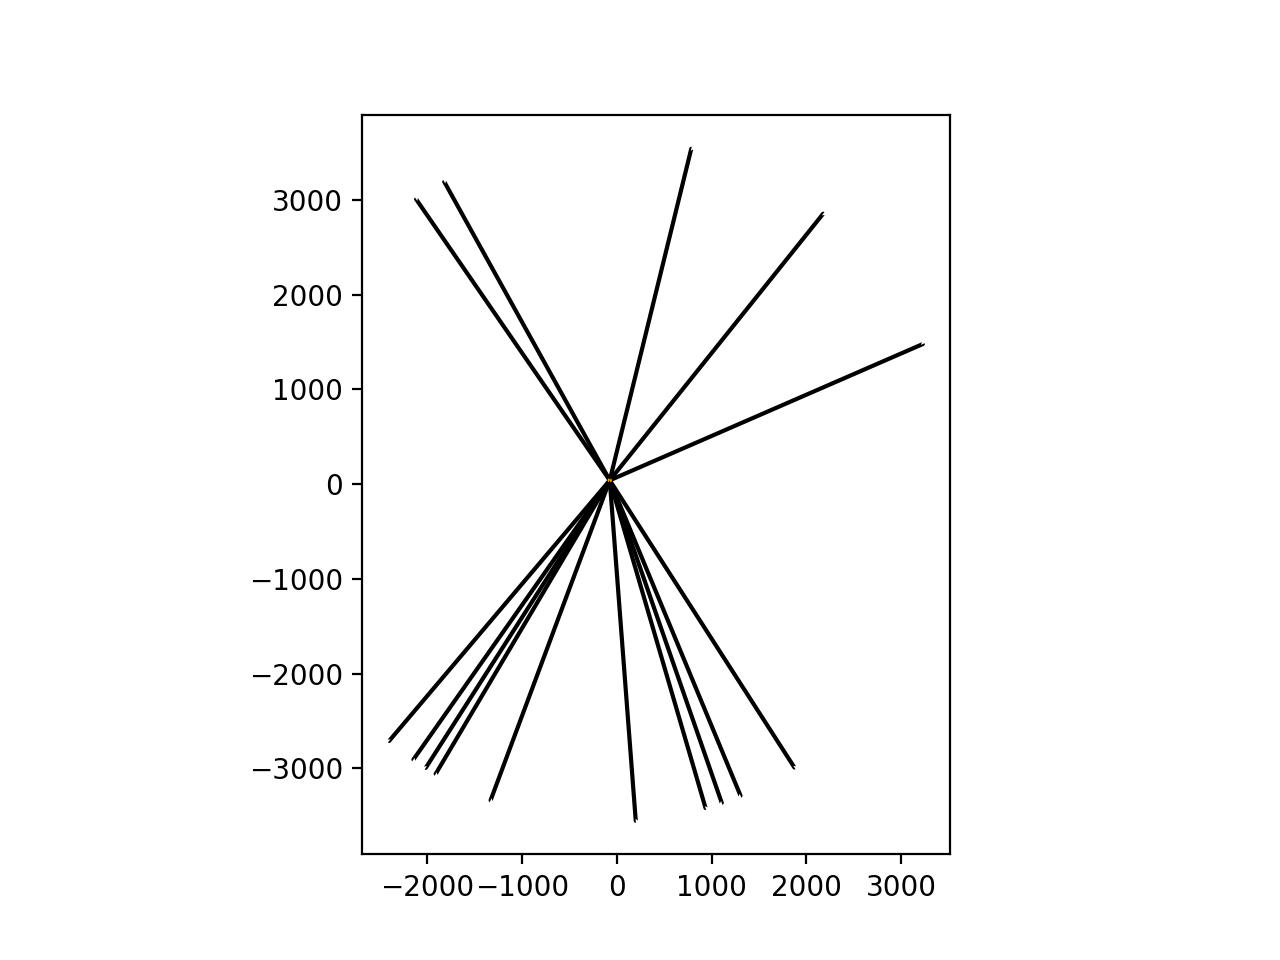

In [43]:
base = streetnewdata.plot(color='white', edgecolor='black')
newdata.plot(ax=base, color='green');
df.plot(ax=base, color="orange")

,street name,geometry


In [ ]:
newdata.to_file("out_map.shp")
streetnewdata.to_file("out_street_map.shp")
